# OPTaaS: Plotting Results
You can use a library like matplotlib to display a live view of your optimization results.

### Set up matplotlib

In [1]:
%matplotlib inline

## Define your scoring function
For this example we will use the [Beale function](https://www.sfu.ca/~ssurjano/beale.html), which is widely used for testing optimization algorithms.

In [2]:
def beale_function(x, y):
    xy = x * y
    xy2 = xy * y
    xy3 = xy2 * y
    return ((1.5 - x + xy) ** 2) + ((2.25 - x + xy2) ** 2) + ((2.625 - x + xy3) ** 2)

## Connect to the OPTaaS server and create a Task

In [3]:
from mindfoundry.optaas.client.client import OPTaaSClient
from mindfoundry.optaas.client.goal import Goal
from mindfoundry.optaas.client.parameter import FloatParameter

client = OPTaaSClient('https://optaas.mindfoundry.ai', '<Your OPTaaS API key>')

task = client.create_task(
    title='Beale Optimization',
    parameters=[
        FloatParameter(name='x', minimum=-4.5, maximum=4.5),
        FloatParameter(name='y', minimum=-4.5, maximum=4.5)
    ], 
    goal=Goal.min
)

## Wrap your scoring function in a Plotting function

In [4]:
from IPython.display import clear_output
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

class Plotter:
    @staticmethod
    def make_plotting_function(task, scoring_function):
        return Plotter(task, scoring_function).get_score_and_display_plot
        
    def __init__(self, task, scoring_function):
        self.scoring_function = scoring_function
        self.current_iteration = 0
        self.all_scores = []
        self.best_scores = []
        self.minimise = task.json.get('goal') == "min"
        self.better_of = min if self.minimise else max
        self.best_score = math.inf if self.minimise else -math.inf        
        self.df = pd.DataFrame(columns=[p['name'] for p in task.parameters] + ['score'])

    def get_score_and_display_plot(self, **configuration_values):
        score = self.scoring_function(**configuration_values)
        
        self._update_scores(score)
        self._update_table(configuration_values, score)
        self._plot_scores()

        display(plt.gcf())
        display(self.df)
        plt.close('all')
        
        self.current_iteration += 1
        return score

    def _update_scores(self, score):
        self.all_scores.append(score)
        self.best_score = self.better_of(self.best_score, score)
        self.best_scores.append(self.best_score)
    
    def _update_table(self, configuration_values, score):
        values_with_score = configuration_values.copy()
        values_with_score['score'] = score
        self.df.loc[self.current_iteration] = values_with_score

    def _plot_scores(self):
        clear_output(wait=True)
        plt.clf()
        
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(1, 2, 1)
        
        if self.minimise:
            ax.invert_yaxis()
            ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
            if all(score >= 0 for score in self.best_scores):
                ax.set_yscale('log')

        ax.set_ylabel('Score')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xlabel('Iterations')

        ax.plot(self.best_scores, 'g', label='Best so far')
        ax.plot(self.all_scores, 'ok')
        ax.legend()

plotting_function = Plotter.make_plotting_function(task, beale_function)

## Run the Task

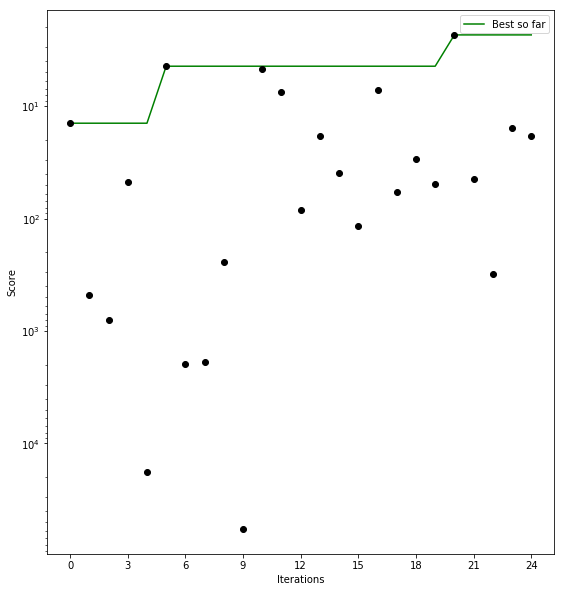

,x,y,score
0,0.000000,0.000000,14.203125
1,-2.250000,2.250000,479.927994
2,2.250000,-2.250000,801.291275
3,-1.125000,-1.125000,47.585869
4,3.375000,3.375000,18123.262255
5,-3.375000,1.125000,4.421380
6,1.125000,-3.375000,1948.978155
7,-1.687500,-2.812500,1903.334630
8,2.812500,1.687500,244.869170
9,-3.937500,3.937500,57777.322420


Iteration: 24    Score: 18.459891669078395
Configuration: {'x': -0.21429106458788935, 'y': -1.1089558008630254}

Task Completed



{ 'configuration': { 'type': 'exploitation',
  'values': {'x': 1.4357503818200903, 'y': -0.2891760183553166}},
  'score': 2.3290336842404216,
  'user_defined_data': None}

In [5]:
task.run(plotting_function, max_iterations=25)